<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>From tensorflow model training to scoring with</b></font><font face="monospace" size="4" color="darkblue"><b> watson-machine-learning-client</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Train TensorFlow model](#model)
3.	[Persist model](#save)
4.	[Deploy model](#deploy)
5.	[Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a lite plan is offered). 
-  Create [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered).
    + After you create COS instance, go to your COS dashboard.
    + In _Service credentials_ tab, click on _New Credential_,
    + Add inline configuration parameter: `{"HMAC":true}`, click _Add_

### 1.1 Working with Cloud Object Storage

`ibm-cos-sdk` library allows Python developers to manage Cloud Object Storage (COS).

In [1]:
import ibm_boto3
from ibm_botocore.client import Config

**Action**: Put authentication information from your instance of Cloud Object Storage service here.

In [2]:
cos_credentials = {
  "apikey": "ESYDu9viaX_QqnEultXPmKWCSI859cmYkb4p9foazqws",
  "cos_hmac_keys": {
    "access_key_id": "fe8d4a595ab8432bb8744707050be508",
    "secret_access_key": "856554fa14c7526a38a226aa023ce871e176eb1d6c041f31"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/f52968f3dbbe7b0b53e15743d45e5e90:ee19ec1e-10a4-4b77-96c5-e3d01f5ae813::",
  "iam_apikey_name": "auto-generated-apikey-fe8d4a59-5ab8-432b-b874-4707050be508",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/f52968f3dbbe7b0b53e15743d45e5e90::serviceid:ServiceId-ab373668-89dc-4846-883d-a76ea0eb5dca",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/f52968f3dbbe7b0b53e15743d45e5e90:ee19ec1e-10a4-4b77-96c5-e3d01f5ae813::"
}

**Action:** Define the service endpoint we will use. <br>
**Tip:** You can find this information in _Endpoints_ section of your Cloud Object Storage intance's dashbord.

In [3]:
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

You also need IBM Cloud authorization endpoint to be able to create COS resource object.

In [4]:
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

We create COS resource to be able to write data to Cloud Object Storage.

In [5]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets (they have to have unique names), we will use to store training data and training results.

In [6]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['trainining-data-caffe' + bucket_uid, 'train-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "train-data-a85da3d5-1122-4705-b579-63c30c4e5f7b"...
Creating bucket "train-results-a85da3d5-1122-4705-b579-63c30c4e5f7b"...


In [7]:
cos.create_bucket(Bucket='caffe-data')

s3.Bucket(name='caffe-data')

In [15]:
import wget
wget.download('https://github.com/umitmertcakmak/Datasets/raw/master/caffe_data.zip')

'caffe_data.zip'

In [16]:
!ls

caffe_data.zip		       MNIST_DATA
GoSales_Tx_NaiveBayes (1).csv  tf-softmax-model.zip
GoSales_Tx_NaiveBayes.csv      WA_Fn%20UseC_%20Telco%20Customer%20Churn.csv
MNIST_data


In [19]:
!unzip caffe_data.zip

Archive:  caffe_data.zip
  inflating: mnist_test_lmdb/data.mdb  
  inflating: mnist_test_lmdb/lock.mdb  
  inflating: mnist_train_lmdb/data.mdb  
  inflating: mnist_train_lmdb/lock.mdb  


In [20]:
!ls

caffe_data.zip		       mnist_test_lmdb
GoSales_Tx_NaiveBayes (1).csv  mnist_train_lmdb
GoSales_Tx_NaiveBayes.csv      tf-softmax-model.zip
MNIST_data		       WA_Fn%20UseC_%20Telco%20Customer%20Churn.csv
MNIST_DATA


In [30]:
filename = "mnist_train_lmdb/lock.mdb"

In [31]:
cos.Bucket("caffe-data").put_object(Body=filename, Key=filename)

s3.Object(bucket_name='caffe-data', key='mnist_train_lmdb/lock.mdb')

In [ ]:
cos.put_object(Bucket='caffe-data',Key=directoryname/filename)

Now we should have 2 buckets,

### 1.2 Downloading training data and upload it to COS buckets.

Let's download our training data and upload them to 'training-data' bucket.
We will create a list of links for training dataset

In [8]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

Below snippet will upload files from links to your Cloud Object Storage.

In [6]:
buckets

NameError: name 'buckets' is not defined

In [9]:
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Let's see the list of all created buckets and their contents.

In [10]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

train-data-a85da3d5-1122-4705-b579-63c30c4e5f7b
  File: t10k-images-idx3-ubyte.gz, 1610.23kB
  File: t10k-labels-idx1-ubyte.gz, 4.44kB
  File: train-images-idx3-ubyte.gz, 9680.10kB
  File: train-labels-idx1-ubyte.gz, 28.20kB
train-results-a85da3d5-1122-4705-b579-63c30c4e5f7b


We are done with Cloud Object Storage, we are ready to train our model!

<a id="model"></a>
## 2. Train model

### 2.1 Work with the instance

In [11]:
import urllib3, requests, json, base64, time, os

In [12]:
!pip install dask --upgrade

Requirement already up-to-date: dask in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages


Authenticate to Watson Machine Learning service on Bluemix.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.

In [13]:
wml_credentials={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

#### Install `watson-machine-learning-client` from pypi

In [14]:
!pip uninstall -y watson-machine-learning-client

Uninstalling watson-machine-learning-client-0.3.323:
  Successfully uninstalled watson-machine-learning-client-0.3.323


If above install fails due to "AssertionError: Multiple .dist-info ...", please uninstall client library and remove the build directory with the commands below, then run the pip install again.

    !rm -rf /tmp/<directory-id-found-in-error>/pip-build/watson-machine-learning-client 
    # e.g. directory-id: s130-c0573632d58e90-35c9a7ecf27a

In [15]:
!pip install --upgrade watson-machine-learning-client --user

  Using cached watson_machine_learning_client-0.3.323-py2.py3-none-any.whl
Requirement already up-to-date: lomond in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tabulate in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tqdm in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: requests in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: urllib3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site

#### Import `watson-machine-learning-client` and authenticate to service instance

In [16]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [17]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 2.2 Save model definition 

#### Prepare model definition metadata

In [18]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "my_definition",
            client.repository.DefinitionMetaNames.DESCRIPTION: "my_description",
            client.repository.DefinitionMetaNames.AUTHOR_NAME: "John Smith",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "js@js.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.2",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20"
            }

#### Get sample model definition content file from git

In [19]:
if os.path.isfile('tf-softmax-model.zip'):
    !ls tf-softmax-model.zip
else:
    !wget https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip
    !ls tf-softmax-model.zip

tf-softmax-model.zip


#### Publish training definition in Watson Machine Learning repository

In [20]:
definition_details = client.repository.store_definition('tf-softmax-model.zip', model_definition_metadata)

In [21]:
definition_url = client.repository.get_definition_url(definition_details)

In [22]:
print(definition_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/a3675de9-c928-4bc6-9209-d7032a8f72b0


### 2.3 Train model

#### Prepare training configuration

**Action:** Put authentication information from your instance of Object Storage service here.
- `TRAINING_DATA_REFERENCE` (reference to uploaded training data)
- `TRAINING_RESULTS_REFERENCE` (location where trained model will be saved)

In [23]:
training_configuration_metadata = {
            client.training.ConfigurationMetaNames.NAME: "Hand-written Digit Recognition",
            client.training.ConfigurationMetaNames.AUTHOR_NAME: "John Smith",
            client.training.ConfigurationMetaNames.AUTHOR_EMAIL: "JohnSmith@js.com",
            client.training.ConfigurationMetaNames.DESCRIPTION: "Hand-written Digit Recognition training",
            client.training.ConfigurationMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.training.ConfigurationMetaNames.FRAMEWORK_VERSION: "1.2-py3",
            client.training.ConfigurationMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20",
            client.training.ConfigurationMetaNames.EXECUTION_RESOURCE_SIZE: "small",
            client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
                    "connection": {
                        "endpoint_url": service_endpoint,
                        "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                        "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                    },
                    "source": {
                        "bucket": buckets[0],
                    },
                    "type": "s3"
                },
            client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
                "connection": {
                    "endpoint_url": service_endpoint,
                    "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                    "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                },
                "target": {
                    "bucket": buckets[1],
                },
                "type": "s3"
            },
        }

#### Train the model in the background

In [24]:
training_run_details = client.training.run(training_configuration_metadata, definition_url=definition_url)

In [25]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

You can check status of training run by calling below method.

In [26]:
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "metrics": [],
  "submitted_at": "2018-01-09T15:40:03Z",
  "state": "pending",
  "current_at": "2018-01-09T15:40:06Z"
}


#### Monitor training log

You can turn on training log monitoring by calling below method.

In [27]:
client.training.monitor(training_run_guid_async)

Log monitor started.
Status: PENDING

Training with training/test data at:
  DATA_DIR: /job/train-data-a85da3d5-1122-4705-b579-63c30c4e5f7b
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: python3 tensorflow_mnist_softmax.py --trainingIters 20

Storing trained model at:
  RESULT_DIR: /job/train-results-a85da3d5-1122-4705-b579-63c30c4e5f7b
BAZEL_VERSION=0.4.5
CI_BUILD_PYTHON=python3

CUDA_PKG_VERSION=8-0=8.0.61-1
CUDA_VERSION=8.0.61
CUDNN_VERSION=5.1.10

DATA_DIR=/job/train-data-a85da3d5-1122-4705-b579-63c30c4e5f7b

GPU_COUNT=1.000000
HOME=/root
JOB_STATE_DIR=/job

LD_LIBRARY_PATH=/usr/local/cuda/extras/CUPTI/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64/stubs
LEARNER_ID=1
LIBRARY_PATH=/usr/local/cuda/lib64/stubs:

MODEL_DIR=/job/model-code
OLDPWD=/root
PATH=/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin

PROMETHEUS_PORT=tcp://172.21.91.116:9090

PROMETHEUS_PORT_9090_TCP=tcp://172.21.91.

#### Cancel training

You can cancel training run by calling below method.

#### Train the model in active mode

**Tip:** You can also run training in synchronous mode by setting `asynchronous = False`

In [28]:
training_run_details = client.training.run(training_configuration_metadata, definition_url=definition_url, asynchronous=False)

Training of training-IzhbJAukR started ...
Elapsed time: 0.17855119705200195 -> training state: pending


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 10.331209421157837 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 20.49891448020935 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 30.659260749816895 -> training state: running



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Training of 'training-IzhbJAukR' finished successfully.


You can see the status of training run similarly as before

In [29]:
training_run_guid_sync = client.training.get_run_uid(training_run_details)

In [36]:
status = client.training.get_status(training_run_guid_sync)
print(json.dumps(status, indent=2))

{
  "submitted_at": "2018-01-09T15:41:13Z",
  "state": "completed",
  "total_iterations": 0,
  "metrics": [],
  "finished_at": "2018-01-09T15:41:35Z",
  "current_at": "2018-01-09T15:41:43Z",
  "current_iteration": 0,
  "message": "NORMAL_OPERATION"
}


<a id="model"></a>
## 3. Persist model

#### Call this method to save model in Watson Machine Learning repository

In [31]:
saved_model_details = client.repository.store_model(training_run_guid_async, "My cool mnist model")

In [32]:
print("Url: " + client.repository.get_model_url(saved_model_details))

Url: https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/f8ab17a2-b135-464f-aa03-cb32fda0670a


**Tip:** Run below code to extract stored model guid from dictionary.

In [33]:
model_guid = client.repository.get_model_uid(saved_model_details)
print("Saved model guid: " + model_guid)

Saved model guid: f8ab17a2-b135-464f-aa03-cb32fda0670a


#### Call this method to list stored models

In [34]:
client.repository.list()

------------------------------------  -----------------------------------------  ------------------------  -----------------  ----------
GUID                                  NAME                                       CREATED                   FRAMEWORK          TYPE
a3675de9-c928-4bc6-9209-d7032a8f72b0  my_definition                              2018-01-09T15:36:21.634Z  tensorflow         definition
a0b964e7-dbc9-4631-8ea2-87896c3fc43f  my_training_definition                     2017-11-17T10:42:44.647Z  tensorflow         definition
12f06353-f8da-4ce3-be53-4c5800ea5969  my_training_definition                     2017-11-20T15:07:26.129Z  tensorflow         definition
9a1b2d9e-805f-4665-b663-8b161244e4ea  my_training_definition                     2017-11-17T09:59:10.991Z  tensorflow         definition
0d57fee6-c259-400c-b600-c369fb00263b  LOCALLY created agaricus prediction model  2017-12-14T14:43:16.141Z  scikit-learn-0.17  model
8ea591dc-5aa3-46c2-a532-ea6858b96c94  LOCALLY create

#### Delete training-run and its results

You can delete train runs and results by running below method.

In [38]:
client.training.delete(training_run_guid_async)
client.training.delete(training_run_guid_sync)

## 5. Create online deployment

You can deployed stored model as webservice (online) by running below method.

In [39]:
deployment_details = client.deployments.create(name="Mnist model deployment", model_uid=model_guid)

In [40]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e200f419-d1d6-488f-bf7b-35a3bc6e80c8/published_models/f8ab17a2-b135-464f-aa03-cb32fda0670a/deployments/e9e2b802-90bf-4060-9f89-20a320a97fa1/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [41]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [42]:
image1 = mnist.test.images[45,].tolist()
image2 = mnist.test.images[4,].tolist()

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

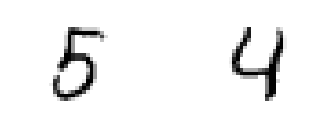

In [44]:
for i, image in enumerate([image1, image2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow( (np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

Build scoring disctionary consisting of two digits and send it to deployed model to get predictions.

In [45]:
scoring_data = {'inputs': [image1, image2]}

In [46]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'classes': [5, 4]}


<a id="summary"></a>
## 6. Summary and next steps     

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to train and score TensorFlow models. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist in IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.